In [346]:
import face_recognition
import pickle
import argparse
import os
import numpy as np
import pandas as pd
from skimage import io
from helper.face_detection import detect_faces
from PIL import Image
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import cv2
%matplotlib inline

# Prepare Image Used

In [347]:
source_file = pd.read_csv("../data/train.csv")
training_path = "../data/raw/Training/{}"
data_observation_id = 67
observation_folder_path = training_path.format(source_file.loc[data_observation_id]["nomor"])
filenames = os.listdir(observation_folder_path)

In [348]:
images_path_inside_folder = ["../data/raw/Training/{}/{}".format(source_file.loc[data_observation_id]["nomor"], filename)  for filename in filenames]

In [349]:
images = [io.imread(image_path) for image_path in images_path_inside_folder ]
len(images)

3

In [350]:
faces_detected = [(n, detect_faces(img)) for n, img in enumerate(images)]
faces_detected

[(0, [(223, 163, 330, 271)]),
 (1, [(497, 497, 626, 626)]),
 (2,
  [(474, 226, 563, 315),
   (225, 146, 315, 236),
   (663, 265, 753, 355),
   (776, 138, 851, 213),
   (305, 265, 394, 355)])]

In [351]:
extracted_face_detected = []

for item in faces_detected:
    (img_index, face_rect) = item
    if len(face_rect) > 1:
        for face in face_rect:
             extracted_face_detected.append((img_index, face))
    else:
        extracted_face_detected.append((img_index, face_rect[0]))

extracted_face_detected[0]

(0, (223, 163, 330, 271))

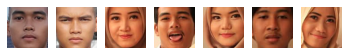

In [352]:
list_face_image = []
for n, (img_index, face_rect) in enumerate(extracted_face_detected):
    face = Image.fromarray(images[img_index]).crop(face_rect)
    list_face_image.append(face)
    plt.subplot(1, len(extracted_face_detected), n+1)
    plt.axis('off')
    plt.imshow(face)

In [353]:
len(list_face_image)

7

# Clustering Image

In [368]:
# encode image to array
list_encoded_face = [face_recognition.face_encodings(np.asarray(img)) for img in list_face_image]
def filter_encoded_face(encode):
    return len(encode) > 0
list_encoded_face_filtered = [filtered[0] for filtered in list(filter(lambda encode: len(encode) > 0, list_encoded_face))]
len(list_encoded_face_filtered)

7

In [355]:
k_mean_cluster = KMeans(n_clusters=len(list_encoded_face_filtered)//2)
k_mean_cluster.fit(list_encoded_face_filtered)
k_mean_cluster.labels_

array([0, 0, 1, 0, 1, 2, 1], dtype=int32)

In [356]:
dbscan_cluster = DBSCAN(min_samples=len(list_encoded_face_filtered))
dbscan_cluster.fit(list_encoded_face_filtered)
dbscan_cluster.labels_

array([-1, -1, -1, -1, -1, -1, -1])

In [362]:
agglomerative_cluster = AgglomerativeClustering()
agglomerative_cluster.fit(list_encoded_face_filtered)
mode_label = stats.mode( np.array(agglomerative_cluster.labels_))[0][0]
mode_label

0

In [367]:
agglomerative_cluster.labels_

array([0, 0, 1, 0, 1, 0, 1])